# Figure 10: MHC class I divergence 

#### Evolutionary divergence 
#### Functional divergence: https://www.science.org/doi/10.1126/science.adk0777 
#### Functional divergence based on NetMHCpan-4.1
#### for cancer phenotype, I will use diagnosed.cancer1 column (note this is a different column!)

# Set up

In [97]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from myfunctions import transform_format


In [98]:
# get current date 
timestr = time.strftime("%Y%m%d") 

In [99]:
# specify font size for plotting 
plt.rcParams.update({'font.sans-serif':'Arial'})

# Load datasets

## MHC genotype (UKBB)

In [100]:

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df_hla = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df_hla.columns = head 

# QUALITY CONTROL (check how genotyping went)
# count in how many cases we're not sure on the allele genotype
df_hla1 = df_hla.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df_hla.filter(regex='^(Person_|D)') # 488377 cases 

df_hla1_count_05 = df_hla1.values.flatten().tolist().count(0.5)
df_hla1_count_15 = df_hla1.values.flatten().tolist().count(1.5)

df_hla2_count_05 = df_hla2.values.flatten().tolist().count(0.5)
df_hla2_count_15 = df_hla2.values.flatten().tolist().count(1.5)

print('Number of 0.5 typing for HLA class I:', df_hla1_count_05)
print('Number of 1.5 typing for HLA class I:', df_hla1_count_15)
print('Number of 0.5 typing for HLA class II:', df_hla2_count_05)
print('Number of 1.5 typing for HLA class II:', df_hla2_count_15)

# SELECT MHC CLASS I and CLASS II
df_hla1 = df_hla.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df_hla.filter(regex='^(Person_|D)') # 488377 cases 

# FILTERING (separately for MHC class I and MHC class II)
# filtering wise: exclude individuals with 0.5 genotype
# if someone is genotyped as 1.5, change to 2 
# this is the filtering used in https://www.science.org/doi/10.1126/science.adi3808, I think it makes sense so I will stick with this 
df_clean_hla1 = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # exclude people for whom we lack a genotype
df_clean_hla1 = df_clean_hla1[~df_clean_hla1.isin([1.5]).any(axis=1)] # exclude people for whom we lack a genotype

df_clean_hla2 = df_hla2[~df_hla2.isin([0.5]).any(axis=1)] # exclude people for whom we lack a genotype
df_clean_hla2 = df_clean_hla2[~df_clean_hla2.isin([1.5]).any(axis=1)] # exclude people for whom we lack a genotype

print("Number of samples with genotype data:", df_hla.shape[0])

# SPLIT MHC class II into DRB / DP / DQ
df_hla2_dp = df_clean_hla2.filter(regex='^(Person_|DP)')
df_hla2_dq = df_clean_hla2.filter(regex='^(Person_|DQ)')
df_hla2_dr = df_clean_hla2.filter(regex='^(Person_|DR)')

# obtain lists of Pariticipant IDs with correctly typed MHC data
ids_mhc1 = df_clean_hla1.Person_ID.unique()
ids_mhc2 = df_clean_hla2.Person_ID.unique()
ids_mhc1_mhc2 = set(ids_mhc1).intersection(set(ids_mhc2)) # intersection 

print("Number of samples which were correctly genotyped for MHC class I:", len(ids_mhc1))
print("Number of samples which were correctly genotyped for MHC class II:", len(ids_mhc2))
print("Number of samples which were correctly genotyped for MHC class I and class II:", len(ids_mhc1_mhc2))

# NOTE
# Because there is a different number of people with correctly typed MHC class I vs class II alleles
# I will first analyse these separately and then will do analysis of MHC class I + class II on these who only have both class I and class II correct 
# I want to run stuff separately to not lose valuable data ofc 

Number of 0.5 typing for HLA class I: 45538
Number of 1.5 typing for HLA class I: 2565
Number of 0.5 typing for HLA class II: 106986
Number of 1.5 typing for HLA class II: 25163
Number of samples with genotype data: 488377
Number of samples which were correctly genotyped for MHC class I: 443620
Number of samples which were correctly genotyped for MHC class II: 378317
Number of samples which were correctly genotyped for MHC class I and class II: 346968


# Heterozygosity status

In [101]:

# add columns to indicate heterozygosity status 

# define a function to get names of columns which indicate alleles present in the sample 
def get_columns_with_values(row, subset_columns):
    return [col for col in subset_columns if row[col] > 0]
    

In [102]:

# apply function to class I alleles

# reminder: filtered data to use: df_clean_hla1, df_clean_hla2

# filter columns with MHC class I alleles (start with A_, B_, C_)
subset_A = [col for col in df_clean_hla1.columns if col.startswith(('A_'))]
subset_B = [col for col in df_clean_hla1.columns if col.startswith(('B_'))]
subset_C = [col for col in df_clean_hla1.columns if col.startswith(('C_'))]

subsets_1 = [subset_A, subset_B, subset_C]

for subset in subsets_1:
    
    new_column_name = 'allele_I_' + subset[0][0] # the first letter will indicate class
    df_clean_hla1[new_column_name] = df_clean_hla1.apply(get_columns_with_values, axis=1, subset_columns=subset).apply(lambda x: ', '.join(x))

df_clean_hla1.head(n = 5)

,Person_ID,A_101,A_102,A_103,A_201,A_202,A_203,A_205,A_206,A_207,...,C_1504,C_1505,C_1601,C_1602,C_1604,C_1701,C_1801,allele_I_A,allele_I_B,allele_I_C
0,2812213,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_201,"B_4001, B_4402","C_304, C_501"
1,4860169,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_101,"B_801, B_5701","C_602, C_701"
2,3381323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"A_2301, A_2402","B_1801, B_5701","C_501, C_602"
3,2805252,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_101,"B_702, B_5701","C_602, C_702"
4,1118855,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"A_201, A_1101","B_5501, B_5701","C_303, C_602"


In [103]:

# apply function to class II alleles

subset_DR = [col for col in df_clean_hla2.columns if 'DRB1' in col] # this is the only one we want to look at at the moment 
subset_DPA = [col for col in df_clean_hla2.columns if 'DPA' in col]
subset_DPB = [col for col in df_clean_hla2.columns if 'DPB' in col]
subset_DQA = [col for col in df_clean_hla2.columns if 'DQA' in col]
subset_DQB = [col for col in df_clean_hla2.columns if 'DQB' in col]

subsets_2 = [subset_DR, subset_DPA, subset_DPB, subset_DQA, subset_DQB]

for subset in subsets_2:
    
    new_column_name = 'allele_II_' + subset[0][:3] # the first three letters indicate class
    df_clean_hla2[new_column_name] = df_clean_hla2.apply(get_columns_with_values, axis=1, subset_columns=subset).apply(lambda x: ', '.join(x))

df_clean_hla2.head(n = 5)

,Person_ID,DRB5_101,DRB5_102,DRB5_202,DRB5_9901,DRB4_101,DRB4_103,DRB4_9901,DRB3_101,DRB3_202,...,DPA1_107,DPA1_201,DPA1_202,DPA1_301,DPA1_401,allele_II_DRB,allele_II_DPA,allele_II_DPB,allele_II_DQA,allele_II_DQB
1,4860169,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"DRB1_301, DRB1_1501",DPA1_103,"DPB1_301, DPB1_401","DQA1_102, DQA1_501","DQB1_201, DQB1_602"
2,3381323,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"DRB1_101, DRB1_401",DPA1_103,"DPB1_201, DPB1_401","DQA1_101, DQA1_301","DQB1_302, DQB1_501"
3,2805252,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,"DRB1_401, DRB1_1501","DPA1_103, DPA1_202","DPB1_101, DPB1_401","DQA1_102, DQA1_301","DQB1_301, DQB1_602"
5,3318036,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,DRB1_701,DPA1_201,DPB1_1101,DQA1_201,DQB1_202
6,4120291,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,"DRB1_103, DRB1_701",DPA1_201,"DPB1_1001, DPB1_1101","DQA1_101, DQA1_201","DQB1_202, DQB1_501"


In [104]:

# define a function to check if someone is heterozygous for a given class of alleles 
def is_heterozygous_allele(row, col):

    # count the number of alleles someone has 
    # count the number of commas + add 1 = number of entires
    count = row[col].count(',') + 1  
    
    # determine if they are heterozygous or homozygous 
    if count == 2:
        return True # has two alleles so heterozygous
    elif count == 1:
        return False # has 1 alleles so homozygous
    else:
        return None # we definitely should not have anything else !!! so return None and see in how many cases this happens

In [105]:
# list of columns we want to look at to determine heterozygosity status
columns_hla1 = ['allele_I_A', 'allele_I_B', 'allele_I_C']
columns_hla2 = ['allele_II_DRB', 'allele_II_DPA', 'allele_II_DPB', 'allele_II_DQA', 'allele_II_DQB']

for col in columns_hla1:
    new_column_name = 'het_' + col # the first three letters indicate class
    df_clean_hla1[new_column_name] = df_clean_hla1.apply(is_heterozygous_allele, axis=1, col = col) # add relevant column to the dataframe

for col in columns_hla2:
    new_column_name = 'het_' + col # the first three letters indicate class
    df_clean_hla2[new_column_name] = df_clean_hla2.apply(is_heterozygous_allele, axis=1, col = col) # add relevant column to the dataframe

In [106]:

# add total heterozygosity 
subset_classI = [col for col in df_clean_hla1.columns if col.startswith(('A_', 'B_', 'C_'))] # all class I alleles 
subset_classII = [col for col in df_clean_hla2.columns if col.startswith(('D'))] # all class II alleles 

# determine the number of unique alleles typed (so if someone has HLA_A0101, HLA_A0101, HLA_B0101, HLA_B0101, HLA_C0101, HLA_C0101, the count is 3)
df_clean_hla1['count_class_I'] = df_clean_hla1[subset_classI].gt(0).sum(axis=1)
df_clean_hla2['count_class_II'] = df_clean_hla2[subset_classII].gt(0).sum(axis=1)

# this is so we get only counts for the 10 alleles we are looking at
subset_classII_drb = [col for col in df_clean_hla2.columns if col.startswith('DRB1') or col.startswith('DP') or col.startswith(('DQ'))] # all class II alleles 
df_clean_hla2['count_class_II_drb'] = df_clean_hla2[subset_classII_drb].gt(0).sum(axis=1)

# determine the number of alleles typed (so if someone has HLA_A0101, HLA_A0101, HLA_B0101, HLA_B0101, HLA_C0101, HLA_C0101, the sum is 6)
df_clean_hla1['sum_class_I'] = df_clean_hla1[subset_classI].sum(axis=1)
df_clean_hla2['sum_class_II'] = df_clean_hla2[subset_classII].sum(axis=1)

# note that some people may not have been fully genotyped > I guess we should think about what to do with these cases 
df_clean_hla1['het_all_class_I'] = (df_clean_hla1['count_class_I'] == 6) # we dropped people who did not have genotype data available so if they dont have 6 alleles they are homozygous by our definition
df_clean_hla2['het_all_class_II'] = (df_clean_hla2['count_class_II'] == 10) 

# one way to check for total heterozygosity is to see whether you have 'TRUE' in all fields (het_allele A, B, C / het allele DRB, DPA, DPB, DQA, DQB)
df_clean_hla1['het_all_class_I_from_allele'] = (df_clean_hla1['het_allele_I_A'] & df_clean_hla1['het_allele_I_B'] & df_clean_hla1['het_allele_I_C'])
df_clean_hla2['het_all_class_II_from_allele'] = (df_clean_hla2['het_allele_II_DRB'] & df_clean_hla2['het_allele_II_DPB'] &df_clean_hla2['het_allele_II_DPA'] & df_clean_hla2['het_allele_II_DQB'] & df_clean_hla2['het_allele_II_DQA'])


# Add phenotype + outcome data (cancer)

In [107]:

# load datasets with phenotypic data (dataset from Hamish McGregor, sent on 28/02/2024)

pheno_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/pheno_info20230504.tsv', sep = '\t')
ancestry_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_iadmix_ancestry_props.csv')

# make sure we have consistent naming for Person_ID column 
pheno_df = pheno_df.rename(columns={'ID_v0': 'Person_ID'}) 
ancestry_df = ancestry_df.rename(columns={'ukbid': 'Person_ID'}) 

# clean up datasets: IDs < 0 participants resigned from the study 
pheno_df = pheno_df[pheno_df.Person_ID > 0] # only retain participants with IDs greater than 0
ancestry_df = ancestry_df[ancestry_df.Person_ID > 0] # only retain participants with IDs greater than 0

# check how many people you have the data for
ids_pheno_data = pheno_df.Person_ID.unique()
ids_ancestry_data = ancestry_df.Person_ID.unique()

print('Number of people with phenotypic data available:', len(ids_pheno_data))
print('Number of people with ancestry data available:', len(ids_ancestry_data))

# identify people for whom both are available
ids_pheno_ancestry = set(ids_pheno_data).intersection(set(ids_ancestry_data)) # intersection 
print('Number of people with phenotypic and ancestry data available:', len(ids_pheno_ancestry))

ids_pheno_ancestry_mhc = set(ids_pheno_ancestry).intersection(set(ids_mhc1_mhc2)) # intersection 
print('Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I and II:', len(ids_pheno_ancestry_mhc))


Number of people with phenotypic data available: 502368
Number of people with ancestry data available: 502603
Number of people with phenotypic and ancestry data available: 502366
Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I and II: 346796


In [108]:

# create ancestry main column
ancestry_df_main = ancestry_df[['Person_ID', 'iadmix_main_ancestry_v2']]

ancestry_df_main['iadmix_main_ancestry_v2'] = pd.Categorical(ancestry_df_main['iadmix_main_ancestry_v2']) 
admix_dummies = pd.get_dummies(ancestry_df_main['iadmix_main_ancestry_v2'])
admix_dummies = admix_dummies.astype(int)
admix_df = pd.concat([ancestry_df_main, admix_dummies], axis=1)
admix_df = admix_df.drop('iadmix_main_ancestry_v2', axis = 1)
admix_df

,Person_ID,AFR,EAS,EUR,Mixed,SAS
13,1000017,0,0,1,0,0
14,1000025,0,0,1,0,0
15,1000038,0,0,1,0,0
16,1000042,0,0,1,0,0
17,1000056,0,0,1,0,0
...,...,...,...,...,...,...
502611,6026161,0,0,1,0,0
502612,6026174,0,0,1,0,0
502613,6026189,0,0,1,0,0
502614,6026193,0,0,1,0,0


## Cancer outcomes

In [109]:
# for phenotype, we will be looking at the diagnosed.cancer1 column
# this contains ICD-10 cancer codes 
# load the dataset with code descriptors
cancer_codes_desc = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/cancer_codes_desc.csv')
cancer_codes_desc

,ICD_code,description,classification
0,C00,oral cancer,head_and_neck
1,C01,oral cancer,head_and_neck
2,C02,oral cancer,head_and_neck
3,C03,oral cancer,head_and_neck
4,C04,oral cancer,head_and_neck
...,...,...,...
85,C94,leukemia,lymphatic_hematopoietic
86,C95,leukemia,lymphatic_hematopoietic
87,C96,non-Hodgkin lymphoma,lymphatic_hematopoietic
88,C97,unclassified,other


In [110]:

# what cancers to look at: get codes of cancers which are most common (top 25?)
cancer_counts = pheno_df['diagnosed.cancer1'].value_counts().reset_index() # counts of different cancer codes in the dataset 
cancer_counts.rename(columns = {'diagnosed.cancer1' : 'ICD_code'}, inplace = True)
cancer_counts_desc = pd.merge(cancer_counts,cancer_codes_desc, on = 'ICD_code')

# # identify cancers with > 1000 cases in the UKBB 
cancers_1000_cases = cancer_counts_desc[cancer_counts_desc['count'] >= 1000]
cancers_1000_cases_ids = cancers_1000_cases.ICD_code.tolist()

# identify top 25 most common cancers in the UKBB  
cancers_top25_cases = cancer_counts_desc.iloc[0:24]
cancers_top25_cases_ids = cancers_top25_cases.ICD_code.tolist()

# # save all counts data, can be useful to look at and compare to the actual name 
# pd.DataFrame(cancer_counts).to_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/cancer_counts_UKBB_diagnosed_histology1.csv')

In [111]:

# create outcome table 

# create a quick dataframe with Patient ID and cancer diagnosis (for 25 most common cancers + any cancer)
cancer_df = pheno_df[['Person_ID', 'diagnosed.cancer1']]

# change type of code to int > string
cancer_df['diagnosed.cancer1'] = cancer_df['diagnosed.cancer1'].astype(str)
cancer_df['diagnosed.cancer1'].unique()

# now we want to change it such that we have 25 columns with status for a specific cancer + any cancer (ie diangosed not NaN)
# this is quite a funky way of doing it but it work

# 1 if someone has cancer but 
for index, row in cancer_df.iterrows():
    if row['diagnosed.cancer1'] == 'nan': # do not change NaN values 
        continue
    if row['diagnosed.cancer1'] not in cancers_top25_cases_ids: # if has other cancer, change to 'other'
         cancer_df.at[index, 'diagnosed.cancer1'] = 'other'

# convert to categorical column
cancer_df['diagnosed.cancer1'] = pd.Categorical(cancer_df['diagnosed.cancer1']) 

# prepare 'dummies dataframe'
cancer_dummies = pd.get_dummies(cancer_df['diagnosed.cancer1'])

# add column 'has cancer 
cancer_dummies['has_cancer'] = cancer_dummies.iloc[:, -2].replace({True: 0, False: 1})
cancer_dummies = cancer_dummies.astype(int)

# create the complete dataframe 
cancer_df = pd.concat([cancer_df, cancer_dummies], axis=1)

# add age at first cancer diagnosis 
cancer_age_df = pheno_df[['Person_ID', 'diagnosed.cancer1']]
cancer_df = pd.merge(cancer_df, cancer_age_df, on = 'Person_ID')

# remove the column
cols_to_drop = ['diagnosed.cancer1_x', 'nan']
cols_to_retain = [x for x in cancer_df.columns.tolist() if x not in cols_to_drop]

# this is our dataframe with features (Age, Sex, Smoking, Ehtnic, BMI, Waist + cancer outcomes)
outcome_df = cancer_df[cols_to_retain]


# Dataframe with phenotype features 

In [112]:

# Select features of interest 

# FEATURES: Age, Sex_v0, Genetic.sex_v0, Ever.smoked_v0, Ethnic.background_v0, Body.maxx,index..BMI._v0, Waist.circumference_v1 

# create age column (age at attending assessment centre)
pheno_df['Year.of.attending.assessment.centre_v0'] = pheno_df['Date.of.attending.assessment.centre_v0'].str.split('-').str[0] # determine year of attending assessment centre
pheno_df['Year.of.attending.assessment.centre_v0'] = pheno_df['Year.of.attending.assessment.centre_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 
pheno_df['Year.of.birth_v0'] = pheno_df['Year.of.birth_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 
pheno_df['Age.of.attending.assessment.centre_v0'] = pheno_df['Year.of.attending.assessment.centre_v0'] - pheno_df['Year.of.birth_v0'] # determine age when attended assessment centre
pheno_df['Age.of.attending.assessment.centre_v0'] = pheno_df['Age.of.attending.assessment.centre_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 

# not sure where on Earth I would get the socio-economic index out from
features = ['Person_ID', 'Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0','Ethnic.background_v0', 'Body.mass.index..BMI._v0', 'Waist.circumference_v1'] 
features_df = pheno_df[features]
features_df

,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Ethnic.background_v0,Body.mass.index..BMI._v0,Waist.circumference_v1
0,1000017,65.0,Female,Yes,British,26.9949,NaN
1,1000025,51.0,Female,Yes,British,22.5460,NaN
2,1000038,52.0,Female,No,British,31.5882,NaN
3,1000042,52.0,Male,No,British,29.3210,NaN
4,1000056,65.0,Female,No,British,27.1382,NaN
...,...,...,...,...,...,...,...
502363,6026189,66.0,Female,No,British,29.9548,NaN
502364,6026193,59.0,Female,No,British,30.4491,NaN
502365,6026206,NaN,Male,NaN,NaN,NaN,NaN
502366,6026214,NaN,Female,NaN,NaN,NaN,NaN


In [113]:

# format categorical features correctly

# for binary outcomes, convert to 0 / 1
features_df['Sex_v0'] = features_df['Sex_v0'].replace({'Female': 0, 'Male': 1})
features_df['Ever.smoked_v0'] = features_df['Ever.smoked_v0'].replace({'Yes': 1, 'No': 0})

# for categorical data with no 1 / 0 levels, need to create dummies again 
ethnic_df = features_df[['Person_ID', 'Ethnic.background_v0']]
ethnic_df['Ethnic.background_v0'] = pd.Categorical(ethnic_df['Ethnic.background_v0']) 
ethnic_dummies = pd.get_dummies(ethnic_df['Ethnic.background_v0'])
ethnic_dummies = ethnic_dummies.astype(int) # we want to convert True / False to 1 / 0
ethnic_dummies = ethnic_dummies.drop(['Do not know', 'Prefer not to answer'], axis = 1)
features_df = pd.concat([features_df, ethnic_dummies], axis=1)

features_df = features_df.drop(['Ethnic.background_v0'], axis = 1) # drop columns with incorrect format / that would not be relevant 
features_df

,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,Chinese,Indian,Irish,Mixed,Other ethnic group,Pakistani,White,White and Asian,White and Black African,White and Black Caribbean
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502363,6026189,66.0,0,0.0,29.9548,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502364,6026193,59.0,0,0.0,30.4491,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502365,6026206,NaN,1,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502366,6026214,NaN,0,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
df_sub_hla1 = pd.concat([df_clean_hla1.iloc[:, 0], df_clean_hla1.iloc[:, 218:]], axis=1)
df_sub_hla2 = pd.concat([df_clean_hla2.iloc[:, 0], df_clean_hla2.iloc[:, 154:]], axis=1)

In [115]:

# next, you need to add ancestry (admixture) data to this 
features_df = pd.merge(features_df, admix_df, on = 'Person_ID')

# next, you want to add HLA class I features
df_sub_hla1_bool = df_sub_hla1.replace({False: 0, True: 1}) # replace True / False with 1 / 0 to have this more systematically
features_df_hla1 = pd.merge(features_df, df_sub_hla1_bool, on = 'Person_ID')
features_df_hla1


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,EUR,Mixed_y,SAS,het_allele_I_A,het_allele_I_B,het_allele_I_C,count_class_I,sum_class_I,het_all_class_I,het_all_class_I_from_allele
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,1,0,0,1,1,1,6,6.0,1,1
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,1,0,0,1,1,1,6,6.0,1,1
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,1,0,0,1,1,1,6,6.0,1,1
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,1,0,0,0,1,1,5,6.0,0,0
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,1,0,0,1,1,1,6,6.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443391,6026156,68.0,1,1.0,25.8883,NaN,0,0,0,0,...,1,0,0,1,1,1,6,6.0,1,1
443392,6026161,68.0,0,1.0,21.1127,NaN,0,0,0,0,...,1,0,0,1,1,1,6,6.0,1,1
443393,6026174,66.0,1,1.0,25.4268,NaN,0,0,0,0,...,1,0,0,1,1,1,6,6.0,1,1
443394,6026189,66.0,0,0.0,29.9548,NaN,0,0,0,0,...,1,0,0,1,1,1,6,6.0,1,1


In [116]:

# create a combined df with features and outcome
combined_df = pd.merge(features_df_hla1, outcome_df, on = 'Person_ID')
print('Number of observations:', combined_df.shape[0])
combined_df = combined_df.iloc[:,:-1]
combined_df.head()


Number of observations: 443396


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,C73,C82,C83,C85,C90,C91,C92,D05,other,has_cancer
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Add CH status 

### note: we do not have CH screening results for 80% of the UKBB cohort
you need to subset for people you actually looked at 

In [118]:


# next, add the CH status outcome  
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# Extract dataframes 
for file_name, df in dataframes.items():
    
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign dataframe to the variable 


# Concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])


Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [119]:

# Change numerical variables to integers

batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# Subset and create new useful columns

batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1] # alternative (CH) variant
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0] # reference variant 

# There are some cases where there is no change in amino acids, for now save as NaN 

batch_all['alt_variant'].fillna(batch_all['Amino_acids'], inplace=True)
batch_all['ref_variant'].fillna(batch_all['Amino_acids'], inplace=True)

# Exclude data with singletons (likely errors)

batch_all_ns = batch_all[batch_all['var_depth'] >= 2]

# Number of samples with two variant reads or more 
print('Number of samples carrying more than a single read with the variant sequence:', batch_all_ns.shape[0])
# okay so we have 2823 of these but then note that only 2249 are with CH variants 
# so like 20% of >= 2 reads are not v likely to be real? should conslut with Jamie 

batch_all_ns.head(n = 10)

Number of samples carrying more than a single read with the variant sequence: 2823


,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt_variant,ref_variant
41,2100538,chr17,7674894,0.036364,2,55,R/*,TP53,Cga/Tga,batch_21_annotated_data,*,R
56,2100679,chr2,25234373,0.048780,4,82,R/H,DNMT3A,cGc/cAc,batch_21_annotated_data,H,R
59,2100706,chr2,25234307,0.019417,2,103,P/L,DNMT3A,cCg/cTg,batch_21_annotated_data,L,P
64,2100777,chr2,25240313,0.020833,2,96,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
65,2100788,chr2,25240420,0.131148,8,61,Y/C,DNMT3A,tAc/tGc,batch_21_annotated_data,C,Y
83,2101006,chr2,25240420,0.027778,2,72,Y/S,DNMT3A,tAc/tCc,batch_21_annotated_data,S,Y
109,2101361,chr17,76736877,0.025641,2,78,P/H,SRSF2,cCc/cAc,batch_21_annotated_data,H,P
126,2101637,chr2,25240313,0.021739,2,92,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
130,2101708,chr17,7675088,0.033898,2,59,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R
154,2102011,chr15,90088702,0.097561,4,41,R/Q,IDH2,cGg/cAg,batch_21_annotated_data,Q,R


In [120]:

# Import indexes tested in each batch 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  # Path to ukb files from Hamish 

# Get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# Read each file one by one 

indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():
    
    variable_name = file_name.split('/')[9].split('.')[0]    # Remove file extension
    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


In [121]:

# Find out how many gene_variants were called:

# don't show warnings 
import warnings
warnings.filterwarnings("ignore")

# identify variants called 
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) # specific position in the genome 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str) # change to a specific aa
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

# remove samples that have not been annotated (you can tell from the coordinate what is likely but these could be different mutations)
batch_all_ns = batch_all_ns.dropna(subset=['SYMBOL']) # remove column where gene is not known 
print('Number of samples which have been correctly annotated:', batch_all_ns.shape[0]) # but at each site, you are getting reads modified to sth else 
# ok so sth worked wrong with annotation in only 5 cases > that looks good 

# identify the number of variants in a specific position
num_variants = pd.DataFrame(batch_all_ns['variant_coord_pos'].value_counts())
num_variants = num_variants[num_variants['count']!=0]
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord_pos'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord_pos')
print('Number of variants identified in batches analysed:', num_variants.shape[0]) # but at each site, you are getting reads modiifed to sth else 

# identify the number of positions we looked at
num_sites = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_sites = num_sites[num_sites['count']!=0]
num_sites = num_sites.sort_values(by = 'count')
num_sites['variant_coord'] = num_sites.index
num_sites = num_sites.reset_index(drop=True)
num_sites = num_sites.sort_values(by = 'variant_coord')
print('Number of sites identified in batches analysed:', num_sites.shape[0]) # okay see so you only found 37 sites 


Number of samples which have been correctly annotated: 2818
Number of variants identified in batches analysed: 89
Number of sites identified in batches analysed: 41


In [122]:

# Annotation (using df with variant names and genomic coordinates)

# read in the df with coordinates
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# all coordinates identified in the batches  
coord_out = num_sites['variant_coord'].tolist()

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

# NB we removed one variant bc the coordinates were incorrect

# NOTE: 
# TP53_R249S was searched for but not found in any of the batches so far 
# there have been 5 samples identified (in DNMT3A, at 2 different sites) with variants that I did not originally search for 
# in addition, some of the variants were offset by one base (could have been a deletion / insertion)
# this is why we have differences in the number of sites in the two datasets 


Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [124]:

# identify CH variants typed in the dataset 
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
print('Number of samples with a mutation in a CH-relevant position (with >2 reads):', batch_all_ns.shape[0])
print('Number of patients with a mutation in a CH-relevant position (with >2 reads):', len(batch_all_ns.sample_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.sample_ID.unique()))


Number of variants identified with annotations: 32
Number of samples with a mutation in a CH-relevant position (with >2 reads): 2818
Number of patients with a mutation in a CH-relevant position (with >2 reads): 2761
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214


In [125]:
# get a finalized df 

# drop non-EUR cases (because we have very few of these, and they really affect cancer risk in the dataset)
combined_df_eur = combined_df[combined_df['EUR']==1]

# select only the columns you are interested in (so you don't throw away too much data)
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # cancer outcomes

# NOTE: here you are selecting stuff that will be available to you as features
# you DEFINITELY want count of alleles and maybe that's more informative than A / B / C
cols = ['Person_ID', 'Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'count_class_I', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 'het_all_class_I', 'other', 'has_cancer'] # other useful features / outcomes
cols.extend(cancer_codes) # combine the two lists together  

# drop NaN values
combined_df_clean = combined_df_eur[cols].dropna()

print('Number of people with complete data (features + outcome) available:', combined_df_clean.shape[0])
combined_df_clean.head(n =5)

Number of people with complete data (features + outcome) available: 421972


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,count_class_I,het_allele_I_A,het_allele_I_B,het_allele_I_C,het_all_class_I,other,...,C67,C71,C73,C82,C83,C85,C90,C91,C92,D05
0,1000017,65.0,0,1.0,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,5,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
# add outcome 'has_ch'
ch_cases = batch_gene_vars.sample_ID.unique().tolist()
combined_df_clean['has_ch'] = combined_df_clean.Person_ID.isin(ch_cases).astype(int)

In [127]:

# note that we did not screen everyone for CH so to include this we need to subset to people we actually looked at 
# subset the dataframe to only include individuals who were actually screened for CH

batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:        
        selected_ids.append(globals()[df_name])

ids_examined = pd.concat(selected_ids, ignore_index=True)
print('Number of samples examined for variants:', ids_examined.shape[0])

ids_examined_list = ids_examined['sample_ID'].tolist()
ids_examined_list = [int(id) for id in ids_examined_list]
ids_examined_list = [int(id) for id in ids_examined_list]

combined_df_with_ch = combined_df_clean[combined_df_clean['Person_ID'].isin(ids_examined_list)]

print('Number of people screened for CH (EUR + all data available):', combined_df_with_ch.shape[0])

Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597
Number of people screened for CH (EUR + all data available): 86174


### Prepare df

In [128]:

# rename columns
combined_df_clean.rename(columns = {'Age.of.attending.assessment.centre_v0' : 'Age', 'Sex_v0' : 'Sex', 'Ever.smoked_v0' : 'Ever smoker',
                                    'het_allele_I_A' : 'MHC I A het', 'het_allele_I_B' : 'MHC I B het', 'het_allele_I_C' : 'MHC I C het',
                                    'het_all_class_I' : 'MHC I het (6 alleles)', 'count_class_I' : '# distinct MHC I alleles'}, inplace = True)

# Logistic regression MHC I across all cancer outcomes 

In [129]:
import statsmodels.api as sm

In [130]:
# how to get odds ratio from coefficients you got from the model 
def calculate_odds_ratio(coef):
    return np.exp(coef)


## Model 1: MHC I alone

#### MHC A / B / C het

In [131]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het'] 
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0) # silence output (minimize verbosity)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    features_lm = ['MHC I A het', 'MHC I B het', 'MHC I C het']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_abc.pdf', bbox_inches='tight')
    plt.close()


#### MHC A / B / C het + overall het I status

In [132]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] 
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0) # silence output (minimize verbosity)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    features_lm = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_abc_het.pdf', bbox_inches='tight')
    plt.close()


#### nr of MHC class I alleles 

In [133]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome
    features = ['# distinct MHC I alleles'] 
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0) # silence output (minimize verbosity)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    features_lm = ['# distinct MHC I alleles'] 

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_nr_alleles.pdf', bbox_inches='tight')
    plt.close()


## Model 2: MHC I + add. features (age, sex, smoking)

#### MHC A / B / C het

In [134]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome column 

    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het']
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    if outcome_label in cancer_codes_sex_specific:
        features_lm = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het'] 
    else:
        features_lm = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_abc_socio.pdf', bbox_inches='tight')
    plt.close()


#### MHC A / B / C het + overall het status

In [135]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome column 

    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)']
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    if outcome_label in cancer_codes_sex_specific:
        features_lm = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] 
    else:
        features_lm = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_abc_het_socio.pdf', bbox_inches='tight')
    plt.close()


#### nr distinct MHC I alleles 

In [136]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome column 

    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC I alleles'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles']
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    if outcome_label in cancer_codes_sex_specific:
        features_lm = ['Age', 'Ever smoker', '# distinct MHC I alleles'] 
    else:
        features_lm = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))

        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_nr_dist_alleles_socio.pdf', bbox_inches='tight')
    plt.close()


# MHC class II genotype 

### Prepare the dataset

In [137]:
# okay now it would be good if we could add to this data for NetMHC class II (heterozygosity status)
df_sub_hla2_bool = df_sub_hla2.replace({False: 0, True: 1}) # replace True / False with 1 / 0 to have this more systematically

# add to combined df 
combined_df_clean_mhcii = pd.merge(combined_df_clean, df_sub_hla2_bool)

# convert to 0 / 1
combined_df_clean_mhcii['het_allele_II_DRB'] = combined_df_clean_mhcii['het_allele_II_DRB'].astype(int)
combined_df_clean_mhcii['het_allele_II_DPA'] = combined_df_clean_mhcii['het_allele_II_DPA'].astype(int)
combined_df_clean_mhcii['het_allele_II_DPB'] = combined_df_clean_mhcii['het_allele_II_DPB'].astype(int)
combined_df_clean_mhcii['het_allele_II_DQA'] = combined_df_clean_mhcii['het_allele_II_DQA'].astype(int)
combined_df_clean_mhcii['het_allele_II_DQB'] = combined_df_clean_mhcii['het_allele_II_DQB'].astype(int)
combined_df_clean_mhcii['count_class_II_drb'] = combined_df_clean_mhcii['count_class_II_drb'].astype(int)
combined_df_clean_mhcii['het_all_class_II_from_allele'] = combined_df_clean_mhcii['het_all_class_II_from_allele'].astype(int)

# rename columns
combined_df_clean_mhcii.rename(columns = {'het_allele_II_DRB' : 'MHC II DRB1 het', 'het_allele_II_DPA' : 'MHC II DPA het', 'het_allele_II_DPB' : 'MHC II DPB het',
                                    'het_allele_II_DQA' : 'MHC II DQA het', 'het_allele_II_DQB' : 'MHC II DQB het', 'count_class_II_drb' : '# distinct MHC II alleles',
                                    'het_all_class_II_from_allele' : 'MHC II het (10 alleles)'}, inplace = True)


# Model 1: MHC II alone

#### MHC DRB / DP / DQ het

In [138]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    features = ['MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
  
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhcii_drpq.pdf', bbox_inches='tight')
    plt.close()

#### MHC DRB / DP / DQ het + overall het status

In [139]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    features = ['MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
  
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhcii_drpq_het.pdf', bbox_inches='tight')
    plt.close()

#### MHC II number of distinct alleles 

In [140]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    features = ['# distinct MHC II alleles'] 
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['# distinct MHC II alleles'] 
  
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhcii_nr_alleles.pdf', bbox_inches='tight')
    plt.close()

# Model 2: MHC II + add. features (sex, age, smoking)

#### MHC DRB / DP / DQ het

In [141]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhcii_drpq_socio.pdf', bbox_inches='tight')
    plt.close()

#### MHC DRB / DP / DQ het + overall het status

In [142]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhcii_drpq_het_socio.pdf', bbox_inches='tight')
    plt.close()

#### MHC II number of distinct alleles

In [143]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC II alleles'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC II alleles'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC II alleles'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC II alleles']

    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhcii_nr_alleles_socio.pdf', bbox_inches='tight')
    plt.close()

# MHC class I and MHC class II combined

# Model 1: MHC class I + class II only

#### MHC A B C and DBR DP DQ

In [144]:

# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het'] 
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_abc_drpq.pdf', bbox_inches='tight')
    plt.close()

#### MHC A B C and DRB DP DQ + overall het status

In [145]:

# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_abc_drpq_het.pdf', bbox_inches='tight')
    plt.close()

#### Number of distinct alleles 

In [146]:

# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    features = ['# distinct MHC I alleles', '# distinct MHC II alleles'] 
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['# distinct MHC I alleles', '# distinct MHC II alleles'] 
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['**', '*', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_nr_alleles.pdf', bbox_inches='tight')
    plt.close()

# Model 2: MHC I + MHC II + add.features (sex, age, smoking)

#### MHC A B C and DRB DP DQ

In [147]:

# okay regression is now the same but we want to plot only result relevant to MHC genotype

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het']  
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het']  
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het']  
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_abc_drpq_socio.pdf', bbox_inches='tight')
    plt.close()

#### MHC A B C and DRB DP DQ + overall het status

In [149]:

# okay regression is now the same but we want to plot only result relevant to MHC genotype

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)']  
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)']  
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)']  
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_abc_drpq_het_socio.pdf', bbox_inches='tight')
    plt.close()

#### Number of distinct alleles 

In [150]:

# okay regression is now the same but we want to plot only result relevant to MHC genotype

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']  
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']  
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_nr_alleles_socio.pdf', bbox_inches='tight')
    plt.close()

# Plots by feature

In [151]:
# okay we want to look by feature, not by outcome 
# let's run this model as the number is relevant and features are not correlated 

cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']
    else:
        features = ['Age', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles', 'Sex']  
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

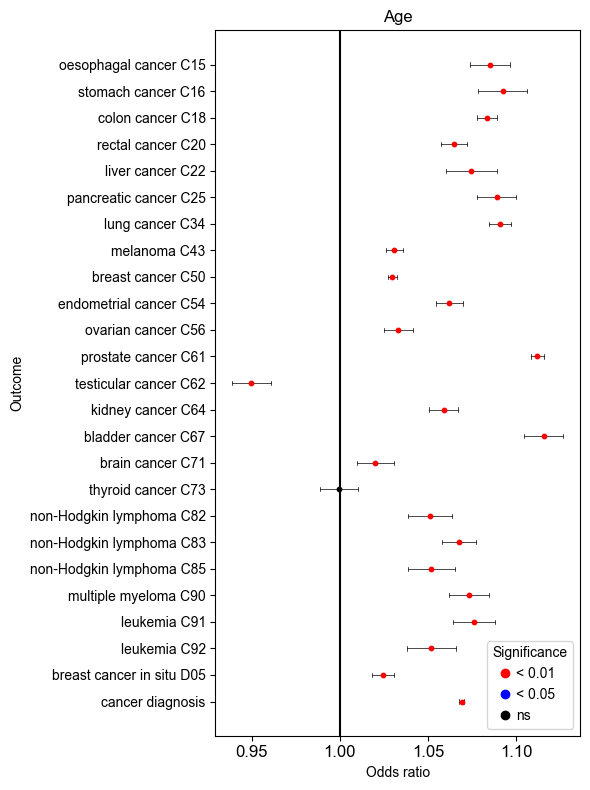

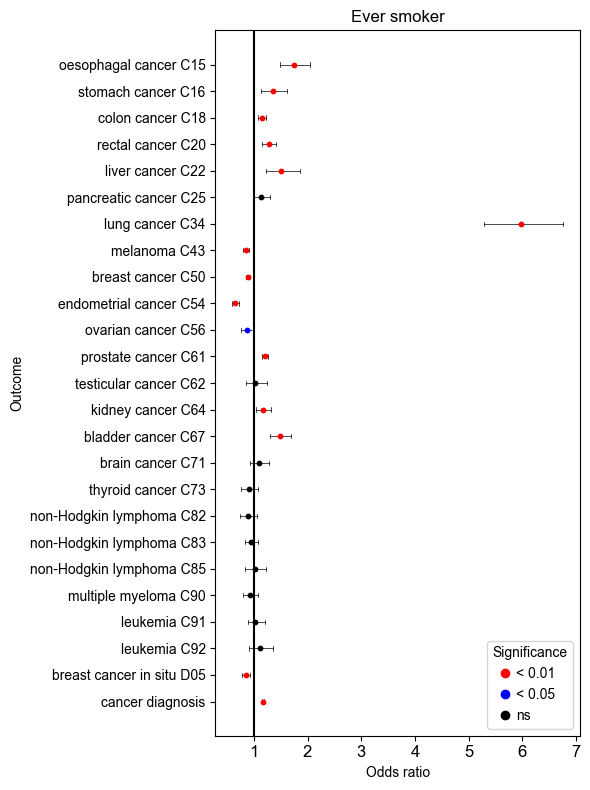

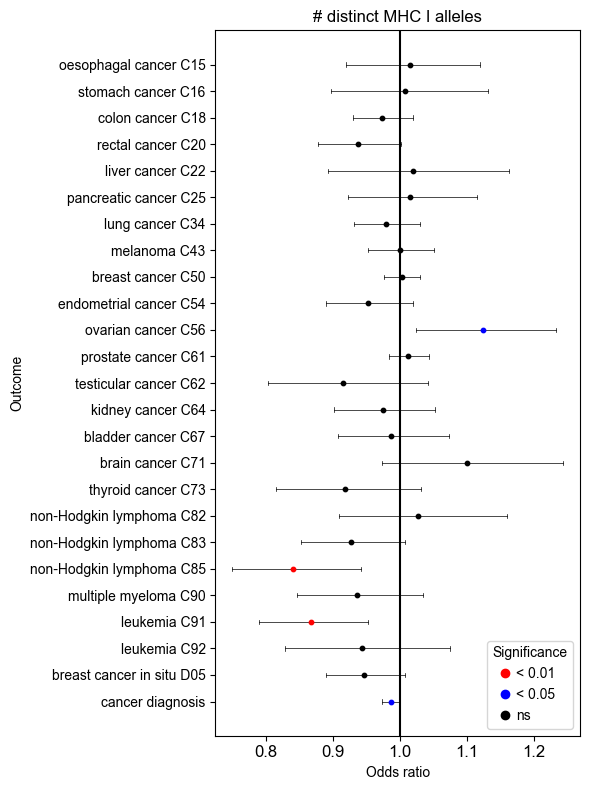

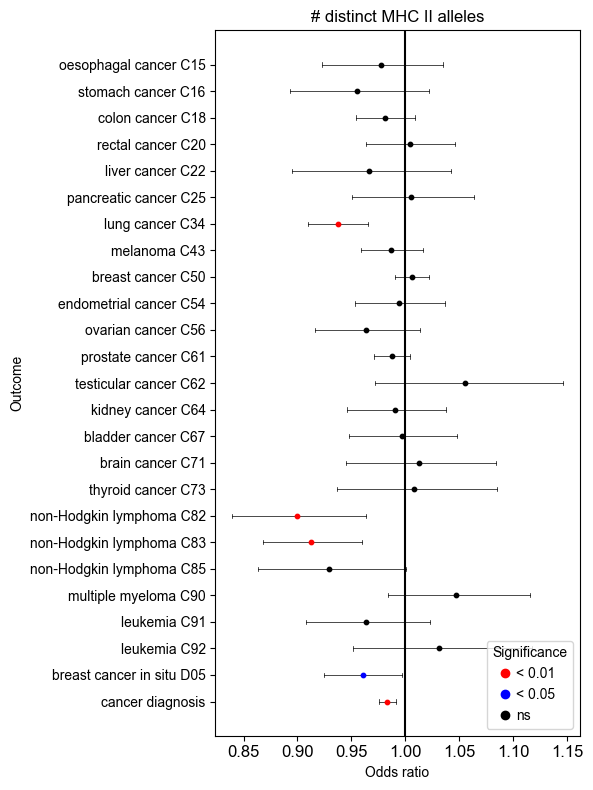

In [153]:

# specify features for which to plot 
features = ['Age', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']

# plot by feature 
for i, feature in enumerate(features):
    
    # separate plot for each feature 
    plt.figure(figsize=(6, 8))
    plt.title(feature)

    descriptors = []
    intercepts = []
    coeffs = []
    lower_confint = []
    upper_confint = []
    coeff_odds_ratios = []
    lower_cis = []
    upper_cis = []
    pvalues_for_outcomes = []
    colors = []

    # identify values for this feature for each outcome 
    for outcome_label, coef_dict in dict_coefficients_mhcii.items():
 
        # identify the outcome (will be on the y axis)
        if outcome_label == 'has_cancer':
            descriptor = 'cancer diagnosis'
        else:
            descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0] + ' ' + outcome_label
        descriptors.append(descriptor)

        # find confidence intervals for the outcome
        # note: the first value is for the intercept so excluding this one 
        confint = dict_confints_mhcii[outcome_label][1:]
        confint = confint.reset_index()

        # specify where to take p values from
        pvalues = dict_pvalues_mhcii[outcome_label][1:]

        # find coefficient values 
        coefficients = dict_coefficients_mhcii[outcome_label][1:]

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        lower_cis.append(lower_ci)
        upper_cis.append(upper_ci)

        pvalue = pvalues[i]
        if pvalues[i] < 0.01: # corresnponds to the number of feature so that works out 
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'

        pvalues_for_outcomes.append(pvalue) 
        colors.append(color)       

    for j, desc in enumerate(descriptors):
        plt.scatter(coeff_odds_ratios[j], desc, alpha = 1, s = 10, color = colors[j], zorder = 2, marker='o')
        plt.plot([lower_cis[j], upper_cis[j]], [desc, desc], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_cis[j], lower_cis[j]], [j-0.08, j+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_cis[j], upper_cis[j]], [j-0.08, j+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')  
    plt.xlabel('Odds ratio')
    plt.ylabel('Outcome')
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_nr_alleles_socio_by_feature.pdf', bbox_inches='tight')


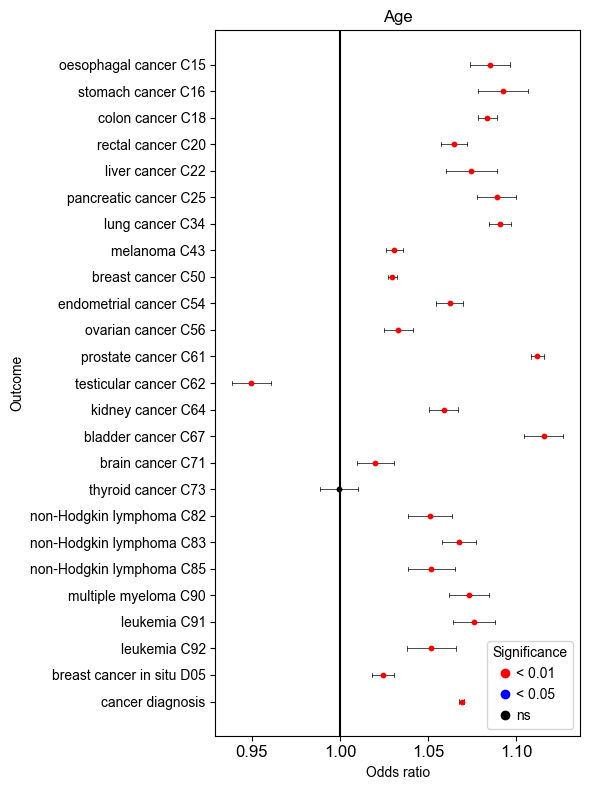

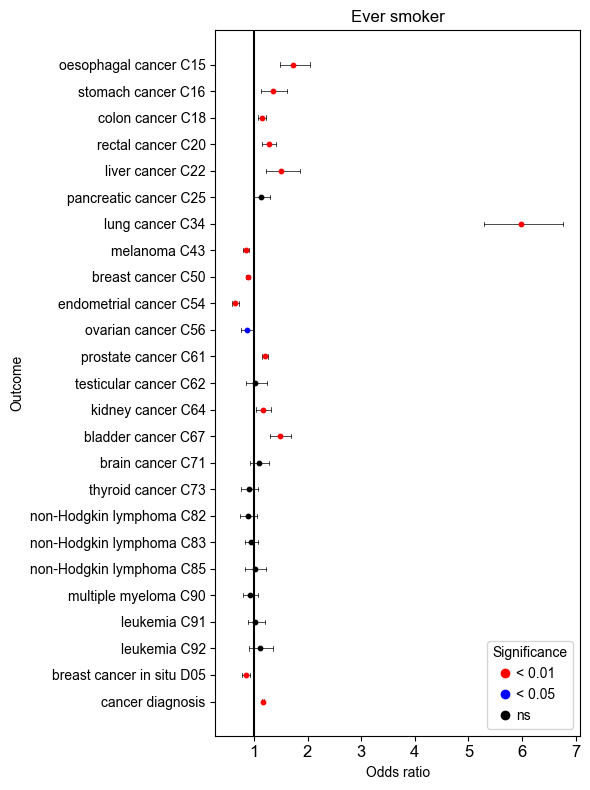

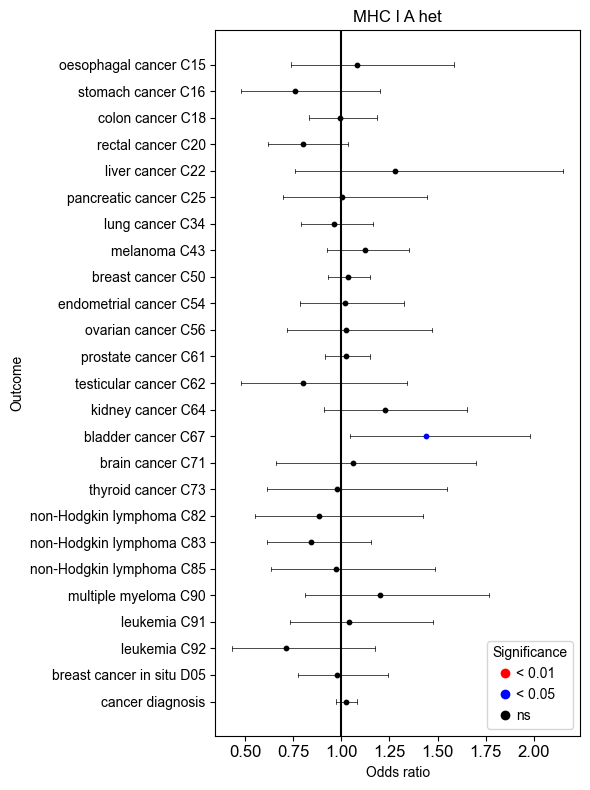

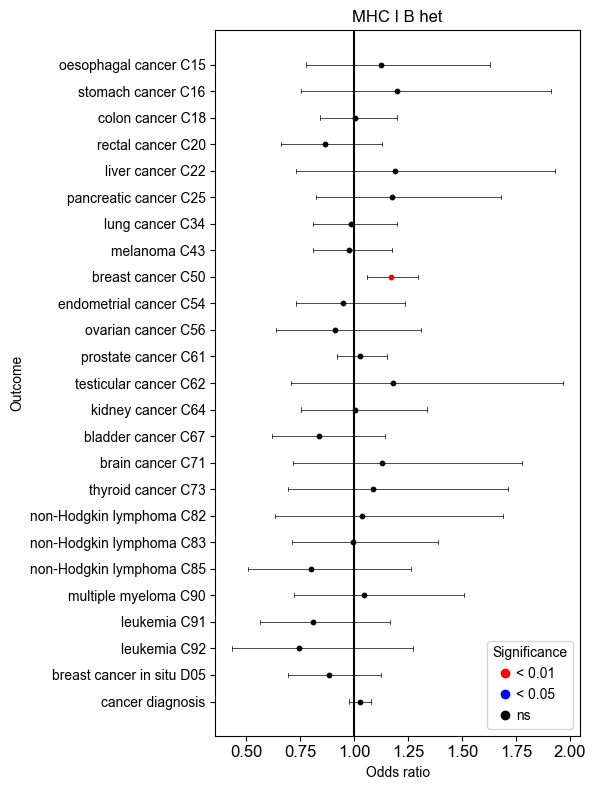

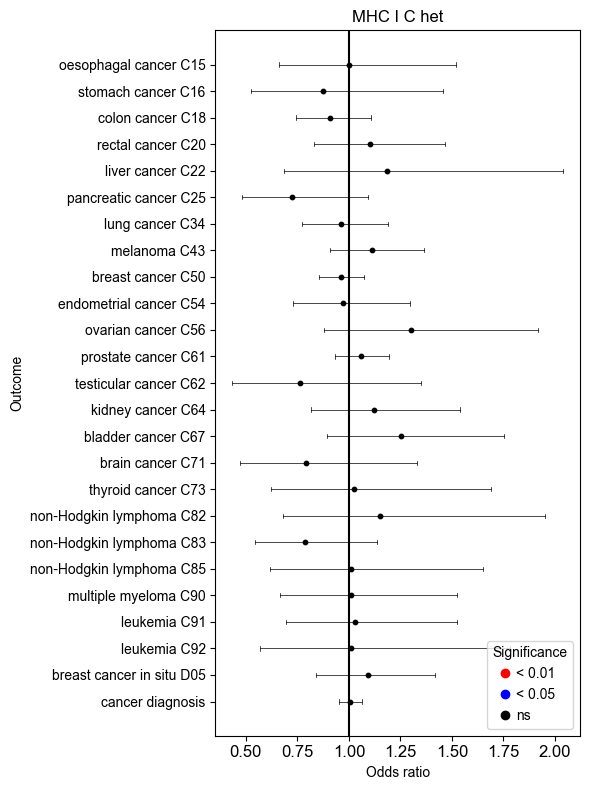

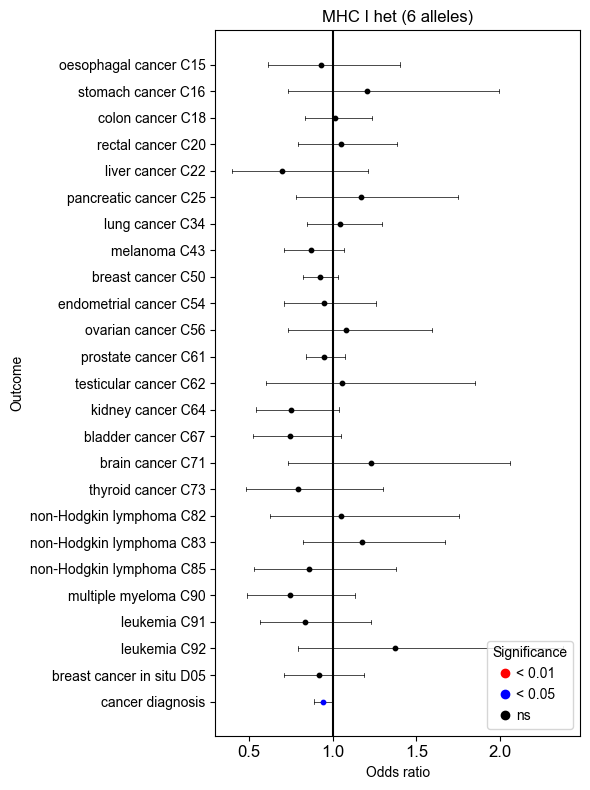

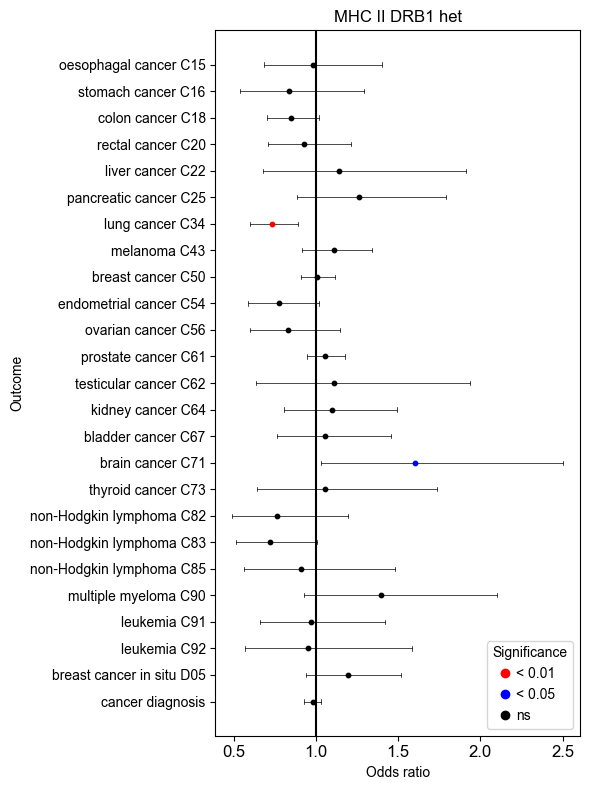

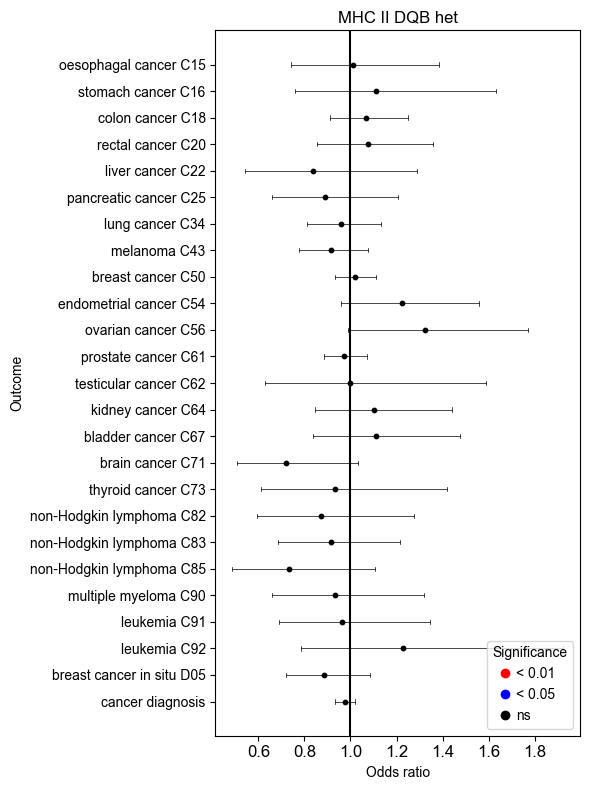

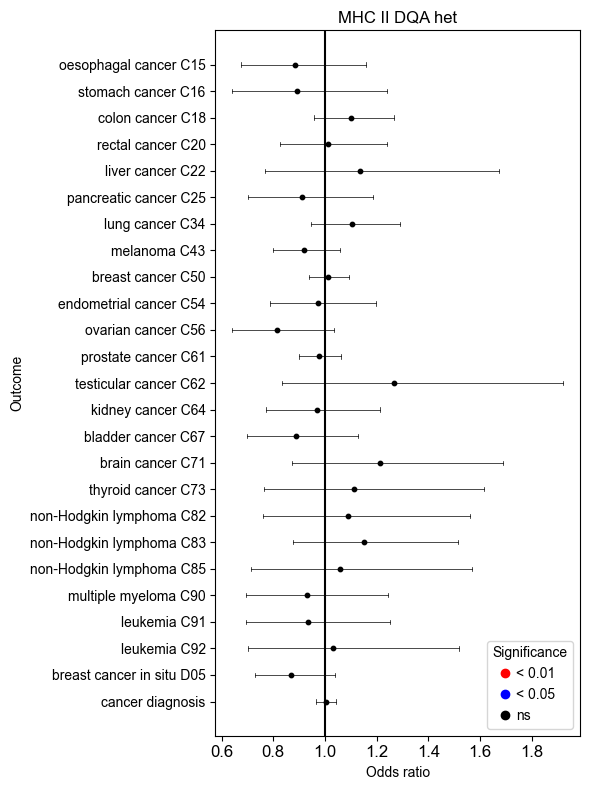

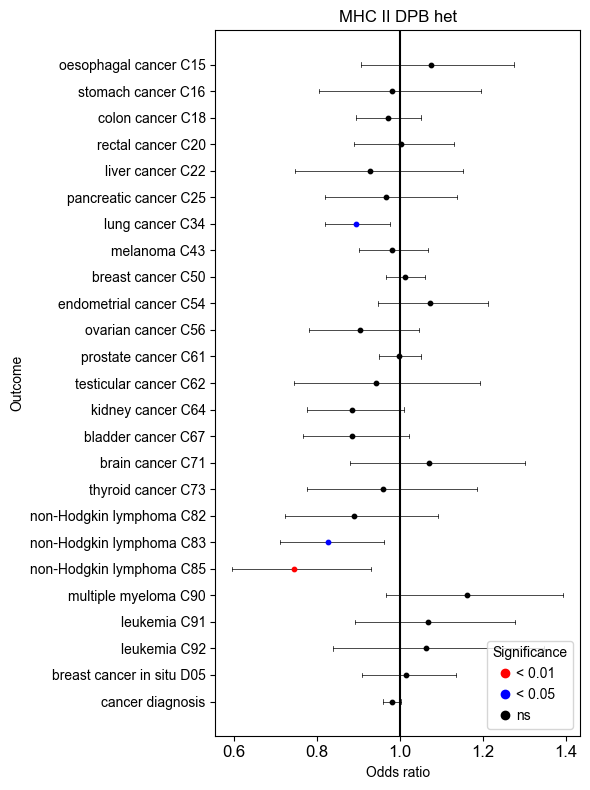

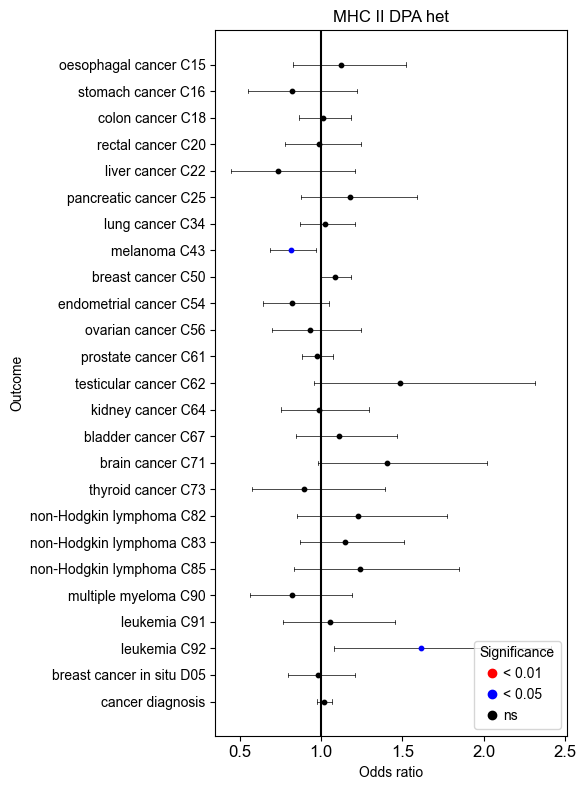

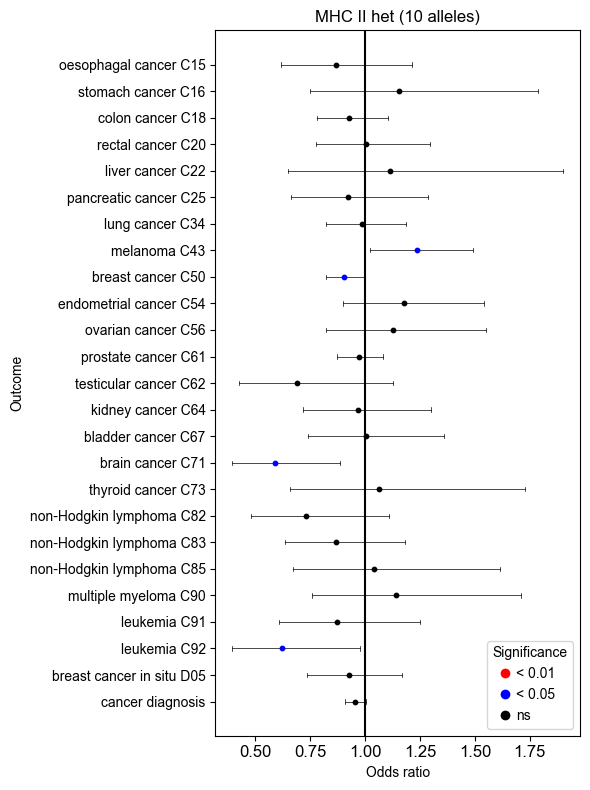

In [154]:
# okay will do this again but now with a different model 
# okay we want to look by feature, not by outcome 
# let's run this model as the number is relevant and features are not correlated 

cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)', 
                    'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)']
    else:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)', 
                    'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)', 'Sex']
        # nb need to include sex as last 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# specify features for which to plot 
features_plot = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)', 
            'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)']

# plot by feature 
for i, feature in enumerate(features_plot):
    
    # separate plot for each feature 
    plt.figure(figsize=(6, 8))
    plt.title(feature)

    descriptors = []
    intercepts = []
    coeffs = []
    lower_confint = []
    upper_confint = []
    coeff_odds_ratios = []
    lower_cis = []
    upper_cis = []
    pvalues_for_outcomes = []
    colors = []

    # identify values for this feature for each outcome 
    for outcome_label, coef_dict in dict_coefficients_mhcii.items():
 
        # identify the outcome (will be on the y axis)
        if outcome_label == 'has_cancer':
            descriptor = 'cancer diagnosis'
        else:
            descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0] + ' ' + outcome_label
        descriptors.append(descriptor)

        # find confidence intervals for the outcome
        # note: the first value is for the intercept so excluding this one 
        confint = dict_confints_mhcii[outcome_label][1:]
        confint = confint.reset_index()

        # specify where to take p values from
        pvalues = dict_pvalues_mhcii[outcome_label][1:]

        # find coefficient values 
        coefficients = dict_coefficients_mhcii[outcome_label][1:]

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        lower_cis.append(lower_ci)
        upper_cis.append(upper_ci)

        pvalue = pvalues[i]
        if pvalues[i] < 0.01: # corresnponds to the number of feature so that works out 
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'

        pvalues_for_outcomes.append(pvalue) 
        colors.append(color)       

    for j, desc in enumerate(descriptors):
        plt.scatter(coeff_odds_ratios[j], desc, alpha = 1, s = 10, color = colors[j], zorder = 2, marker='o')
        plt.plot([lower_cis[j], upper_cis[j]], [desc, desc], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_cis[j], lower_cis[j]], [j-0.08, j+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_cis[j], upper_cis[j]], [j-0.08, j+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')  
    plt.xlabel('Odds ratio')
    plt.ylabel('Outcome')
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_abc_drpq_het_socio_by_feature.pdf', bbox_inches='tight')


# Is there any effect on CH?

In [155]:

# only do this considering people who were actually screened for CH
screened_for_ch = combined_df_with_ch.Person_ID.tolist()
combined_df_clean_with_ch = combined_df_clean_mhcii[combined_df_clean_mhcii['Person_ID'].isin(screened_for_ch)]

#### MHC A B C + MHC DRB1 DP DQ + het status

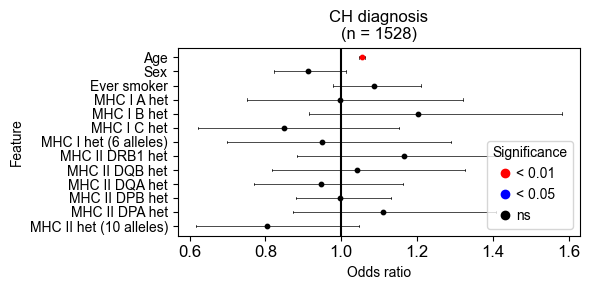

In [156]:

# I am using the code as it is in case I then want to look at other outcomes in this cohort
dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

outcomes = ['has_ch']
for outcome in outcomes:
    
    features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    X = combined_df_clean_with_ch[features]
    y = combined_df_clean_with_ch[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    descriptor = 'CH diagnosis'
    nr_cases = combined_df_clean_with_ch[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_abc_drpq_het_socio.pdf', bbox_inches='tight')


#### MHC class I and class II nr distinct alleles 

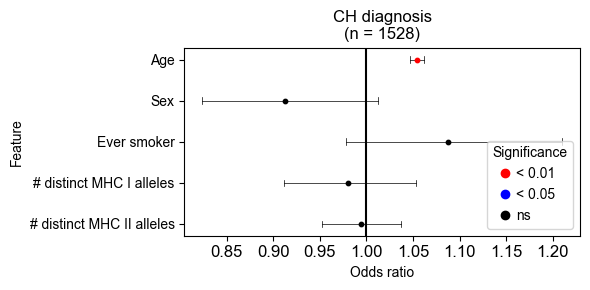

In [157]:
# run logistic regression on whether someone has ch 

# okay regression is now the same but we want to plot only result relevant to MHC genotype

# with more features (ie age, sex, smoking)
# prepare features and outcome column 

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

outcomes = ['has_ch']

for outcome in outcomes:
     
    features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']  
    
    X = combined_df_clean_with_ch[features]
    y = combined_df_clean_with_ch[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    descriptor = 'CH diagnosis'
    nr_cases = combined_df_clean_with_ch.has_ch.sum()
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_dc1_{outcome_label}_mhci_mhcii_nr_alleles_socio.pdf', bbox_inches='tight')


# Looking at lung cancer results (cf Krishna 2024 Science)

Total number of lung cancer cases: 3764
Number of lung cancer cases in non-smokers: 336
Number of lung cancer cases in ever smokers: 3428


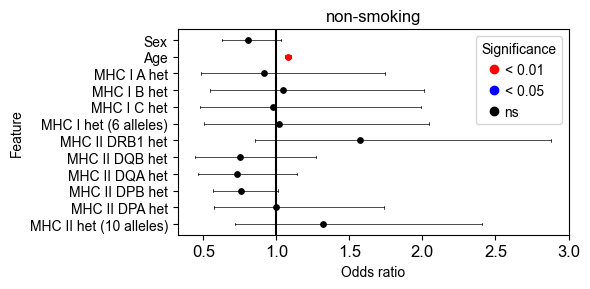

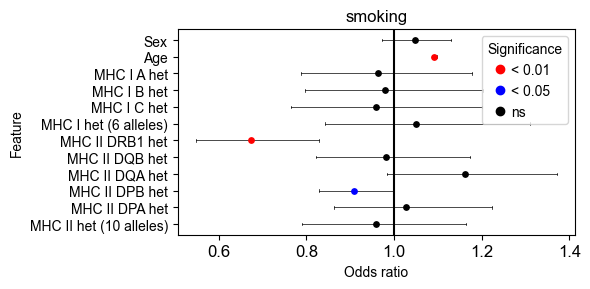

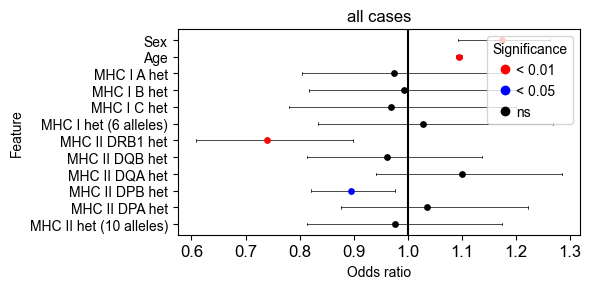

In [158]:

# would be good to see if we can reproduce what Krishna et al observed for lung cancers
# now we will run a model only with MHC-associated parameters (no sex age etc)

# okay first check the numbers
# in Krishna et al, they report 2468 cancer cases
# 1107 current smokers, 1035 former smokers and 326 non-smokers 

print('Total number of lung cancer cases:', combined_df_clean.C34.value_counts().values[1])
print('Number of lung cancer cases in non-smokers:',combined_df_clean[combined_df_clean['Ever smoker']==0].C34.value_counts().values[1])
print('Number of lung cancer cases in ever smokers:',combined_df_clean[combined_df_clean['Ever smoker']==1].C34.value_counts().values[1])

# with more features (ie age, sex, smoking)
# prepare features and outcome column 

dict_intercepts_sm = {}
dict_coefficients_sm = {}
dict_confints_sm = {}
dict_pvalues_sm = {}

smoking_status = [float(0), float(1)]
outcome = 'C34'
features = ['Sex', 'Age', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
            'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 

for smoking in smoking_status:

    combined_df_clean_smoking = combined_df_clean_mhcii[combined_df_clean_mhcii['Ever smoker']==smoking]

    # note: features only MHC-associated 
    X = combined_df_clean_smoking[features]
    y = combined_df_clean_smoking[outcome].astype('bool')
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_sm[smoking] = intercept_multi
    dict_coefficients_sm[smoking] = coeff_multi
    dict_confints_sm[smoking] = confint_multi
    dict_pvalues_sm[smoking] = pvalues_multi

# now take any 
smoking = 'any'
X = combined_df_clean_mhcii[features]
y = combined_df_clean_mhcii[outcome].astype('bool')
model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit(disp = 0)
intercept_multi = result.params[0]
coeff_multi = result.params
confint_multi = result.conf_int()
pvalues_multi = result.pvalues

# save to a dictionary for plotting 
dict_intercepts_sm[smoking] = intercept_multi
dict_coefficients_sm[smoking] = coeff_multi
dict_confints_sm[smoking] = confint_multi
dict_pvalues_sm[smoking] = pvalues_multi
    
# plot results for smokers vs non-smokers

# plot

for smoking, coef_dict in dict_coefficients_sm.items():

    # first, determine what outcome we are looking at 
    if smoking == float(1):
        descriptor = 'smoking'
    elif smoking == float(0):
        descriptor = 'non-smoking'
    elif smoking == 'any':
        descriptor = 'all cases'
    else:
        print('error')

    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))
    plt.title(descriptor)

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_sm[smoking][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients_sm[smoking][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints_sm[smoking]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_sm[smoking][1:] # first p value is for the intercept 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 15, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates
    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_lung_cancer_compare_regression_{smoking}.pdf', bbox_inches='tight')


- okay I am not getting exactly what they got and my confidence intervals are a bit wider
- however, the overall trend is very similar and it feels like the numbers are close enough
- I am really confused given I have more data than they have I should not have larger CIs 
- but it could be that somehow stuff is more variable / I have fewer features